# Источник данных

Источник данных: Johns Hopkins CSSE. Исходные данные доступны в [этом репозитории](https://github.com/CSSEGISandData/COVID-19).

Предобработанный одним из кэгглеров датасет и различные варианты прогнозов и визуализация [доступны на платформе Kaggle](https://www.kaggle.com/imdevskp/corona-virus-report). 

Этот ноутбук создан для моих русскоязычных друзей, проживающих в России.

In [1]:
from datetime import datetime
print('Дата обновления этого ноутбука:')
print(datetime.today())

Дата обновления этого ноутбука:
2020-04-10 09:33:42.727251


In [2]:
import pandas as pd
import numpy as np
import wget
import os

urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']
for filename in os.listdir():
    if 'time_series' in filename:
        os.remove(filename)
for url in urls:
    filename = wget.download(url)

In [3]:
def select_russian_data(data, column_name):
    df = data.copy()
    df = df[df['Country/Region']=='Russia'].reset_index()
    df.drop(columns=['index', 'Province/State', 'Country/Region', 'Lat', 'Long'], inplace=True)
    df = df.T.rename(columns={0: column_name})
    df.index = pd.to_datetime(df.index)
    return df

cases = select_russian_data(pd.read_csv('time_series_covid19_confirmed_global.csv'), 'cases')
deaths = select_russian_data(pd.read_csv('time_series_covid19_deaths_global.csv'), 'deaths')
recovered = select_russian_data(pd.read_csv('time_series_covid19_recovered_global.csv'), 'recovered')

russian_data = cases.merge(deaths, left_index=True, 
                           right_index=True).merge(recovered, left_index=True, right_index=True)

russian_data.index = pd.to_datetime(russian_data.index)
russian_data['cases_a_day'] = russian_data['cases'] - russian_data['cases'].shift(1).fillna(0)

In [4]:
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

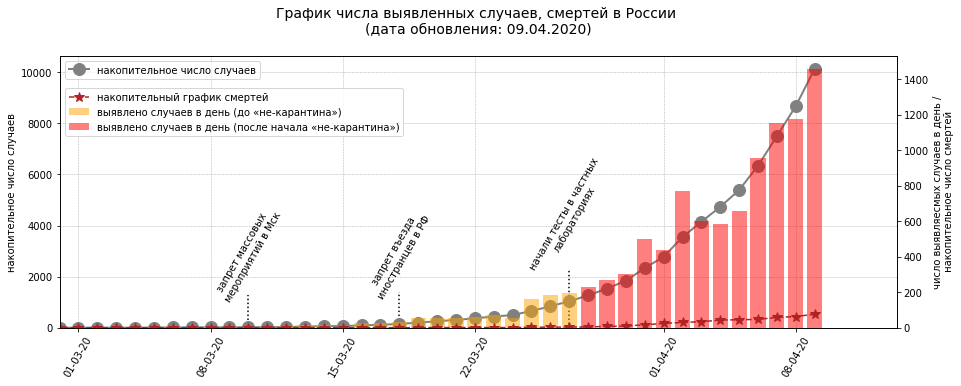

In [5]:
log = False # set True for log scale

start_date = pd.to_datetime('29-02-2020') 
    
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

ax1.plot(russian_data['cases'], color='grey', marker='o', linewidth=2, markersize=12)

event_dict = {pd.to_datetime('03-10-2020'): 'запрет массовых \nмероприятий в Мск',
              pd.to_datetime('03-18-2020'): 'запрет въезда\nиностранцев в РФ',
              pd.to_datetime('03-27-2020'): 'начали тесты в частных\nлабораториях'}
for date, event in event_dict.items():
    height = russian_data.loc[pd.to_datetime('03-10-2020'), 'cases'] + russian_data['cases'].max()
    plt.text(date, 
             russian_data[russian_data.index==date]['cases'][0]+height/10, 
             event, 
             fontsize=10, 
             horizontalalignment='center',
             rotation=60)
    ax1.vlines(date, 0, 
               russian_data[russian_data.index==date]['cases'][0]+height/8, 
               linestyle=':')

if log == True: ax1.set_yscale('log')
    
ax2 = ax1.twinx()
ax2.plot(russian_data['deaths'], color='firebrick', marker='*', linestyle='--', markersize=10)

ax2.bar(x=russian_data[russian_data.index<pd.to_datetime('03-28-2020')].index, 
        height=russian_data[russian_data.index<pd.to_datetime('03-28-2020')]['cases_a_day'], 
        color='orange', alpha=0.5)

ax2.bar(x=russian_data[russian_data.index>=pd.to_datetime('03-28-2020')].index, 
        height=russian_data[russian_data.index>=pd.to_datetime('03-28-2020')]['cases_a_day'], 
        color='red', alpha=0.5)

if log == True: ax2.set_yscale('log')

title = '''График числа выявленных случаев, смертей в России {}
(дата обновления: {:%d.%m.%Y})
'''.format(''.join(['(логарифмическая шкала)' if log else '']), russian_data.index.max())

ax1.set_xlim(start_date)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
ax1.set_ylim(0)
plt.title(title, fontsize=14)
ax1.legend(['накопительное число случаев'])
ax2.legend([ 'накопительный график смертей', 'выявлено случаев в день (до «не-карантина»)',
             'выявлено случаев в день (после начала «не-карантина»)'], 
               loc='upper left', bbox_to_anchor=(0, 0.1, 0.5, 0.8))
ax1.grid(linestyle='--', linewidth=0.5)
ax1.set_ylabel('накопительное число случаев')
ax2.set_ylabel('число выявляесмых случаев в день /\n накопительное число смертей')
plt.savefig('all_cases.png', bbox_inches="tight")
plt.show()

### Приближение экспонентой и кубической параболой

In [6]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c 

def cubic_func(l, a, b, c, d):
    return [a * (x ** 3) + b * (x ** 2) + c * x + d for x in l ]

In [7]:
# Выставляем начало локальной вспышки. Пока считаем от 100 накопленных случаев
russian_data.loc[russian_data['cases']>=100, 'day_count'] = range(1, len(russian_data[russian_data['cases']>=100])+1)
russian_data['day_count'] = russian_data['day_count'].fillna(0).astype(int)

y = 280.336542 * exp(0.151095 * x) + -335.414639
y = 1.054491 * (x ^ 3) + -12.036421 * (x ^ 2) + 97.562053 * x + -5.555336


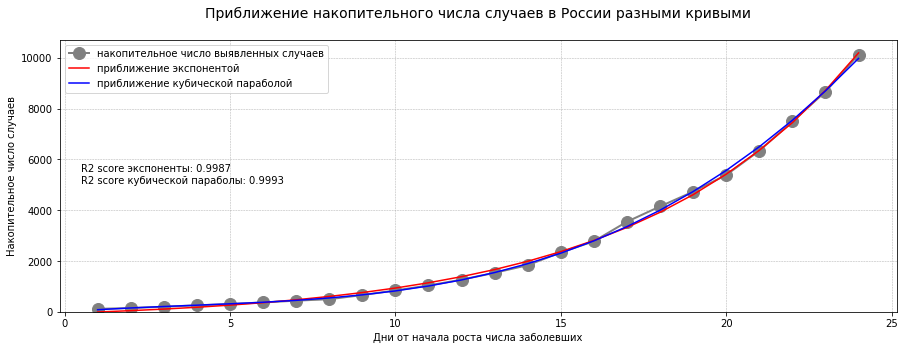

Данные доступны по 09.04.2020

Прогноз на 10.04.2020
--------------------
Прогноз экспонентой: 11916
Прогноз кубической параболой: 11387


In [8]:
ydata = russian_data[russian_data['day_count'] > 0]['cases']
xdata = range(1, len(ydata)+1)

exp_popt, pcov = curve_fit(exp_func, 
                       xdata,
                       ydata)
print('y = %f * exp(%f * x) + %f' % tuple(exp_popt))
cubic_popt, pcov = curve_fit(cubic_func, 
                       xdata,
                       ydata)
print('y = %f * (x ^ 3) + %f * (x ^ 2) + %f * x + %f' % tuple(cubic_popt))

fig, ax1 = plt.subplots(1, 1, figsize=(15,5))

plt.plot(xdata, ydata, label='накопительное число выявленных случаев',
         color='grey', marker='o', linewidth=2, markersize=12)

plt.plot(xdata, exp_func(xdata, *exp_popt), 'r-',
         label='приближение экспонентой')
plt.plot(xdata, cubic_func(xdata, *cubic_popt), 'b-',
         label='приближение кубической параболой')

ax1.grid(linestyle='--', linewidth=0.5)
plt.legend()
plt.ylabel('Накопительное число случаев')
plt.xlabel('Дни от начала роста числа заболевших')
plt.title('Приближение накопительного числа случаев в России разными кривыми\n', fontsize=14)
plt.ylim(0)

r2_scores = [r2_score(ydata, exp_func(xdata, *exp_popt)),
             r2_score(ydata, cubic_func(xdata, *cubic_popt))]

text = '''R2 score экспоненты: {:0.4f}
R2 score кубической параболы: {:0.4f}'''.format(*r2_scores)


plt.text(0.5, ydata.max()/2, text)
plt.show()

next_day = np.array([max(xdata)+1])
predictions = [exp_func(next_day, *exp_popt)[0],
               cubic_func(next_day, *cubic_popt)[0]]

print('Данные доступны по {:%d.%m.%Y}'.format(russian_data.index.max()))
print()
print('Прогноз на {:%d.%m.%Y}'.format(russian_data.index.max()+pd.DateOffset(1)))
print('-'*20)
print('''Прогноз экспонентой: {:0.0f}
Прогноз кубической параболой: {:0.0f}'''.format(*predictions))

# Ситуация по регионам России

Для визуализации используются открытые данные Роспотребнадзора и других органов, собранные в одну таблицу силами активистов. (Спасибо Софии!)

In [9]:
from io import BytesIO
import requests
import geopandas as gpd

In [ ]:
# Границы регионов с OSM
russian_border = gpd.read_file('admin_level_2.geojson')
subjects_borders = gpd.read_file('admin_level_4.geojson')

subjects_borders = subjects_borders.to_crs('epsg:3857')
russian_border = russian_border.to_crs('epsg:3857')

In [ ]:
google_sheet = 'https://docs.google.com/spreadsheets/d/1ZdNZtCBp7yp6-KwuUHB0bd-VN6VbKwRilC6ZX_jwtFE/export?gid=0&format=csv'
raw_data = requests.get(google_sheet).content
russian_regions = pd.read_csv(BytesIO(raw_data), index_col=0,
                             parse_dates=['Дата обновления'],
                             dayfirst=True).set_index('Дата обновления')
russian_regions.columns = [column.replace(' Республика', ' республика') for column in russian_regions.columns]

def correct_region_names(item):
    if item == 'Республика Татарстан':
        return 'Татарстан'
    elif item == 'Кабардино-Балкарская республика':
        return 'Кабардино-Балкария'
    elif item in ['Удмурсткая республика', 'Удмуртская республика']:
        return 'Удмуртия'
    elif item in ['Чувашская республика', 'Республика Чувашия']:
        return 'Чувашия'
    elif item == 'Ханты-Мансийский АО':
        return 'Ханты-Мансийский автономный округ - Югра'
    elif item == 'Республика Башкортостан':
        return 'Башкортостан'
    elif item == 'Республика Адыгея':
        return 'Адыгея'
    elif item == 'Республика Бурятия':
        return 'Бурятия'    
    elif item == 'Республика Дагестан':
        return 'Дагестан'
    elif item == 'Республика Мордовия':
        return 'Мордовия'
    elif item == 'Республика Калмыкия':
        return 'Калмыкия'
    elif item == 'Республика Северная Осетия — Алания':
        return 'Северная Осетия - Алания'
    elif item == 'Республика Марий Эл':
        return 'Марий Эл'
    elif item == 'Республика Ингушетия':
        return 'Ингушетия'
    elif item == 'Карачаево-Черкесская республика':
        return 'Карачаево-Черкесия'
    else:
        return item

russian_regions.columns = [correct_region_names(item) for item in russian_regions.columns]

In [ ]:
region_start_index = russian_regions.columns.tolist().index('Тестов сделано')+1
region_list = russian_regions.columns.tolist()[region_start_index:]
region_list.remove('Сумма по регионам')
region_list.remove('Сумма по регионам отличается от статистики заражений за все время')

not_found_region = []
for item in region_list: # чек, что все имена субъектов корректны
    if item not in subjects_borders['name'].unique():
        not_found_region.append(item)
if len(not_found_region) > 0:
    for el in not_found_region:
        print(el)
    print(subjects_borders['name'].unique())

In [ ]:
last_update = russian_regions.iloc[[-1]][region_list].T
update_date = last_update.columns[0]
last_update = last_update.rename(columns={update_date: 'corona_cases'})

subjects_borders = subjects_borders.merge(last_update, left_on='name', right_index=True, how='left')
subjects_borders['corona_cases'] = subjects_borders['corona_cases'].fillna(0)

In [ ]:
ordered_regions = russian_regions[region_list].max().sort_values(ascending=False).index
bottom = np.array([0] * russian_regions.shape[0])
fig, ax = plt.subplots(1, 1, figsize=(15,5))

for region in ordered_regions:
    plt.bar(x=russian_regions.index.date, 
            height=russian_regions[region].fillna(0).values, 
            bottom=bottom, edgecolor='gray')
    bottom = bottom + russian_regions[region].fillna(0).values
ax.grid(linestyle='--', linewidth=0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
plt.xticks(rotation=60)
plt.title('''Накопительный график случаев коронавируса по субъектам РФ,
информация от {}'''.format(update_date), fontsize=14)
plt.legend(ordered_regions[:5], title="Топ-5 регионов по выявленным случаям:")
ax.set_ylabel('накопительное число случаев')
ax.set_xlim(start_date)
ax.set_ylim(0, russian_regions['Сумма по регионам'].max()+50)

ax_test = ax.twinx()
ax_test.plot(russian_regions['Тестов сделано'], marker='*', markersize=10, color='black')
ax_test.set_ylabel('всего сделано тестов')
plt.show()

In [ ]:
city_df = pd.DataFrame({'name': ['Москва', 'Санкт-Петербург'],
                        'Latitude': [55.45, 59.56],
                        'Longitude': [37.36, 30.18],})
city_df = city_df.merge(last_update, left_on='name', right_index=True, how='left')
cities = gpd.GeoDataFrame(city_df, geometry=gpd.points_from_xy(city_df.Longitude, city_df.Latitude))
cities.crs = 'epsg:4326'
cities = cities.to_crs('epsg:3857')

In [ ]:
sns.set_style('darkgrid')
sns.set_context('notebook')

plt.rcParams['figure.figsize'] = (15, 15)
ax = russian_border.plot(color='white')
cmap = 'OrRd'
subjects_borders[~subjects_borders['name'].isin(cities['name'].unique())].query('corona_cases > 0').plot(ax=ax, 
                                                      column='corona_cases', 
                                                      linewidth=0.5, cmap=cmap)

cities.plot(ax=ax, markersize=cities['corona_cases']/5, color='firebrick', alpha=0.5, legend=True)
ax.set_xlim([0, ax.get_xticks().max()])
ax.set(xticklabels=[], yticklabels=[])
ax.grid(False)

legend_elements = []
for element in cities[['name', 'corona_cases']].to_dict('split')['data']:
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label='{} ({:0.0f} случаев)'.format(*element),
                          markerfacecolor='firebrick', markersize=np.log(element[1])*2))
ax.legend(handles=legend_elements, loc='upper left',
          facecolor='white')


plt.title('''Число случаев коронавируса по субъектам РФ,
информация от {}'''.format(update_date), fontsize=14)

fig = ax.get_figure()
vmin, vmax = 0, round(subjects_borders[~subjects_borders['name'].isin(cities['name'].unique())]['corona_cases'].max())
cax = fig.add_axes([0.9, 0.3, 0.03, 0.4])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
clrbar = fig.colorbar(sm, cax=cax)
plt.savefig('map.png', bbox_inches='tight')
plt.show()